In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import jax.random as random
from utils import MMDVar, compute_mmd_sq, compute_K_matrices, h1_mean_var_gram, MMDu_var
import matplotlib.pyplot as plt
import json
from tqdm.auto import tqdm

/home/oldrain123/miniconda3/envs/mmdenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [4]:
def sample_blobs_Q(N1, sigma_mx_2, rows=3, cols=3, key=None):
    """Generate Blob-D for testing type-II error (or test power)."""
    if key is None:
        key = random.PRNGKey(0)
    
    mu = jnp.zeros(2)
    sigma = jnp.eye(2) * 0.03
    
    key, subkey1, subkey2, subkey3, subkey4 = random.split(key, 5)
    
    X = random.multivariate_normal(subkey1, mean=mu, cov=sigma, shape=(N1,))
    Y = random.multivariate_normal(subkey2, mean=mu, cov=jnp.eye(2), shape=(N1,))
    
    X = X.at[:, 0].add(random.randint(subkey3, (N1,), 0, rows))
    X = X.at[:, 1].add(random.randint(subkey4, (N1,), 0, cols))
    
    key, subkey5, subkey6 = random.split(key, 3)
    Y_row = random.randint(subkey5, (N1,), 0, rows)
    Y_col = random.randint(subkey6, (N1,), 0, cols)
    
    locs = jnp.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]])
    
    for i in range(9):
        corr_sigma = sigma_mx_2[i]
        L = jnp.linalg.cholesky(corr_sigma)
        ind = jnp.expand_dims((Y_row == locs[i][0]) & (Y_col == locs[i][1]), 1)
        ind2 = jnp.concatenate((ind, ind), 1)
        Y = jnp.where(ind2, jnp.matmul(Y,L) + locs[i], Y)
    
    return X, Y

In [5]:
# Generate variance and co-variance matrix of Q
sigma_mx_2_standard = jnp.array([[0.03, 0], [0, 0.03]])
sigma_mx_2 = jnp.zeros((9, 2, 2))
for i in range(9):
    sigma_mx_2 = sigma_mx_2.at[i].set(sigma_mx_2_standard)
    if i < 4:
        sigma_mx_2 = sigma_mx_2.at[i, 0, 1].set(-0.02 - 0.002 * i)
        sigma_mx_2 = sigma_mx_2.at[i, 1, 0].set(-0.02 - 0.002 * i)
    if i == 4:
        sigma_mx_2 = sigma_mx_2.at[i, 0, 1].set(0.00)
        sigma_mx_2 = sigma_mx_2.at[i, 1, 0].set(0.00)
    if i > 4:
        sigma_mx_2 = sigma_mx_2.at[i, 1, 0].set(0.02 + 0.002 * (i - 5))
        sigma_mx_2 = sigma_mx_2.at[i, 0, 1].set(0.02 + 0.002 * (i - 5))

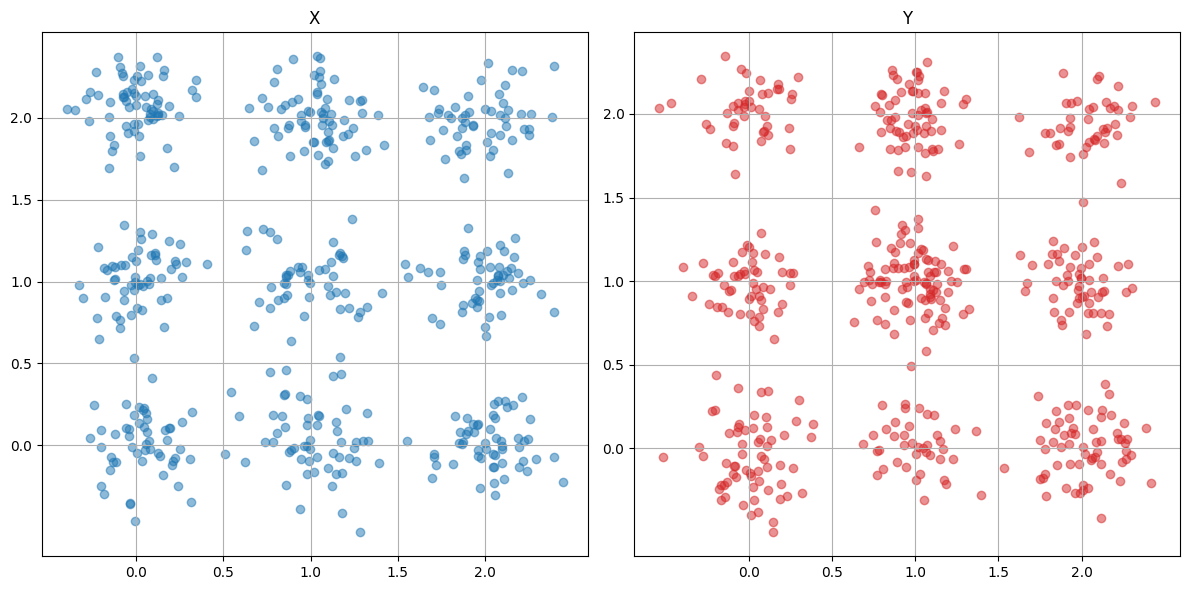

In [20]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

# Assuming the function sample_blobs_Q is already defined

def plot_datasets(X, Y, rows=3, cols=3):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot X
    ax[0].scatter(X[:, 0], X[:, 1], c='tab:blue', alpha=0.5)
    ax[0].set_title('X')
    ax[0].set_xticks([0,0.5, 1, 1.5, 2])
    ax[0].set_yticks([0, 0.5, 1, 1.5, 2])
    ax[0].grid(True)
    
    # Plot Y
    ax[1].scatter(Y[:, 0], Y[:, 1], c='tab:red', alpha=0.5)
    ax[1].set_title('Y')
    ax[1].set_xticks([0, 0.5, 1, 1.5, 2])
    ax[1].set_yticks([0, 0.5, 1, 1.5, 2])
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Sample datasets
X, Y = sample_blobs_Q(500, sigma_mx_2)  # you might need to adjust the number of samples

# Plot datasets on a 3x3 grid
plot_datasets(X, Y)


In [6]:
def simulate_mmd(sigma_mx_2, ratio, num_samples, sigma0):
    mmd_samples = jnp.zeros(num_samples)
    full_vars, complete_vars, incomplete_vars = [], [], []

    key = random.PRNGKey(1203) # Set random seed
    for i in range(num_samples):
        key, subkey = random.split(key)
        
        # Use the sample_blobs_Q function to generate your datasets
        X, Y = sample_blobs_Q(num_samples * ratio, sigma_mx_2, key=subkey)

        Kxx, Kyy, Kxy = compute_K_matrices(X, Y, sigma0)
        mmd_value = compute_mmd_sq(Kxx, Kyy, Kxy, len(X), len(Y))
        mmd_samples = mmd_samples.at[i].set(mmd_value)

        full_vars.append(MMDVar(X, Y, sigma0))
        complete_vars.append(MMDVar(X, Y, sigma0, complete=False))
        incomplete_vars.append(h1_mean_var_gram(Kxx, Kyy, Kxy, is_var_computed=True, use_1sample_U=True)[1])

    return mmd_samples, full_vars, complete_vars, incomplete_vars

In [7]:
ratios = jnp.array([1, 2, 3, 4, 5])  
num_samples = 100
results = {}
print("Running...")
for ratio in tqdm(ratios):
    N1 = num_samples * ratio * 9
    # Use the sample_blobs_Q function to generate your datasets
    X, Y = sample_blobs_Q(N1, sigma_mx_2)
    mmd_samples, full_vars, complete_vars, incomplete_vars = simulate_mmd(sigma_mx_2, ratio, N1, sigma0=1.0)
    true_variance = jnp.var(mmd_samples, ddof=1)
    results[str(ratio)] = {
            'MMDu': jnp.mean(jnp.array(mmd_samples)),
            'true_variance': true_variance,
            'full_variance_estimate': jnp.mean(jnp.array(full_vars)),
            'complete_variance_estimate': jnp.mean(jnp.array(complete_vars)),
            'incomplete_variance_estimate': jnp.mean(jnp.array(incomplete_vars))
        }
    print(results[str(ratio)])

for ratio, vals in results.items():
    print(f"Ratio: {ratio}")
    print(f"MMDu: {vals['MMDu']}")
    print(f"True Variance of MMD: {vals['true_variance']}")
    print(f"Full Variance Estimate (Ours 8): {vals['full_variance_estimate']}")
    print(f"Complete Variance Estimate (Ours 2): {vals['complete_variance_estimate']}")
    print(f"Incomplete Variance Estimate (Liu et al. 2): {vals['incomplete_variance_estimate']}")
    print("-----"*10)

Running...


 20%|██        | 1/5 [02:44<10:56, 164.25s/it]

{'MMDu': Array(0.00010839, dtype=float64), 'true_variance': Array(8.19116384e-07, dtype=float64), 'full_variance_estimate': Array(2.99757498e-06, dtype=float64), 'complete_variance_estimate': Array(1.58394098e-06, dtype=float64), 'incomplete_variance_estimate': Array(1.59290835e-06, dtype=float64)}
